In [ ]:
"""
Chakradhar Koppula

Convolutional Neural Network based on the VGG-16 Architecture (https://arxiv.org/abs/1409.1556) for Animal Classification.

This notebook uses the VGG-16 CNN architecture and initialises the weights to be the pre-trained weights used
with the ImageNet dataset. It then is trained for 15 epochs over the Animals-10 dataset from Kaggle (https://www.kaggle.com/alessiocorrado99/animals10)
and aims to classify an image correctly as 1 of 10 animals.
"""

## Imports

In [4]:
# Imports needed for the notebook

import itertools
import numpy as np
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import applications, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

## Loading Datasets into Colab

In [5]:
# Datasets uploaded to personal Google Drive. Personal Drve then mounted to colab
# for easy access. In event of colab timeout no need to reuplaod entire dataset.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Unzipping training and validation data from drive into colab workspace.
# Folders are named in Spanish.
!7z x "/content/drive/MyDrive/Data.zip"


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/                                 1 file, 613301814 bytes (585 MiB)

Extracting archive: /content/drive/MyDrive/Data.zip
 15% 4096 Open              --
Path = /content/drive/MyDrive/Data.zip
Type = zip
Physical Size = 613301814

  0%      1% 634 - Data/raw-img/cane/OIP-71hHGnFsE08CZBQLDImxmAHaLJ.jpeg                                                                  1% 955 - Data/raw-img/cane/OIP-aIesmsYTfEcYB6JyGx_NOwHaHf.jpeg              

In [7]:
# Unzipping testing data from drive into colab workspace.
# Folders are named in Spanish.
!7z x "/content/drive/MyDrive/test.zip"


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/                                 1 file, 41956428 bytes (41 MiB)

Extracting archive: /content/drive/MyDrive/test.zip
--
Path = /content/drive/MyDrive/test.zip
Type = zip
Physical Size = 41956428

  0%     29% 264 - test/elefante/e83db70c28f3083 . ac104497f5c978a4efb4bb_640.jpg                                                                          75% 705 - test/pecora/e83db40e2bf1053ed158 . 218ac104497f5c978a6eab2b0_640.jpg       

In [8]:
!ls Data/raw-img # Checking that I am able to access the folders correctly

cane	 elefante  gallina  mucca   ragno
cavallo  farfalla  gatto    pecora  scoiattolo


In [9]:
!ls test # Checking that I am able to access the folders correctly

cane	 elefante  gallina  mucca   ragno
cavallo  farfalla  gatto    pecora  scoiattolo


# Constants

In [10]:
# Defining Constants
IMG_WIDTH = 256
IMG_HEIGHT = 256
BATCH_SIZE = 96
EPOCHS = 15
SHEAR_RANGE = 0.2
ZOOM_RANGE = 0.2
VALIDATION_SPLIT = 0.2

## Loading images into training and validation sets

In [11]:
# Creating ImageDataGenerator object in order to load in the training and validation data. 
img_data_gen = ImageDataGenerator(
    rescale=1./255,                     # Rescale used to normalize image values from between 0-255 to between 0-1.
    shear_range=SHEAR_RANGE,            # Shear range use to distort the image along an axis to augment images to accomadate for different viewing angles.
    zoom_range=ZOOM_RANGE,              # Zoom range applies a random zoom to the image to create a more varied dataset.
    horizontal_flip=True,               # Horizontal flip randomly flips images horizontally to create a more varied dataset.
    validation_split=VALIDATION_SPLIT   # 20% of data is being used as validation data during the training process.
)

In [12]:
train_generator = img_data_gen.flow_from_directory(
    'Data/raw-img',
    subset="training",                       # Uses 80% of images in the directory as the training images.
    target_size = (IMG_HEIGHT, IMG_WIDTH),   # Resizes all images to be 256x256x3 (RGB).
    batch_size = BATCH_SIZE                  # Batch size of 96 used, found to be best after experimentation.
)

validation_generator = img_data_gen.flow_from_directory(
    'Data/raw-img',
    subset="validation",                     # Uses 20% of images in the directory as the validation images.
    target_size = (IMG_HEIGHT, IMG_WIDTH),   # Resizes all images to be 256x256x3 (RGB).
    batch_size = BATCH_SIZE                  # Batch size of 96 used, found to be best after experimentation.
)

Found 20947 images belonging to 10 classes.
Found 5232 images belonging to 10 classes.


In [13]:
# Animals in the dataset and their corresponding class indices.
# cane: Dog
# cavallo: Horse
# elefante: Elephant
# farfalla: Butterfly
# gallina: Hen
# gatto: Cat
# mucca: Cow
# pecora: Sheep
# ragno: Spider
# scoiattolo: Squirrel

train_generator.class_indices

{'cane': 0,
 'cavallo': 1,
 'elefante': 2,
 'farfalla': 3,
 'gallina': 4,
 'gatto': 5,
 'mucca': 6,
 'pecora': 7,
 'ragno': 8,
 'scoiattolo': 9}

# Defining the model

In [14]:
# Base VGG-16 model. Dimensions of image passed as input shape. include_top set to false meaning the last 3
# fully connected layers of the model are not included. Allows for me to experiment with this aspect and reduce
# the amount of computation and wieghts needed to be learned by using fewer than 3 final layers.
vgg_model = applications.VGG16(weights='imagenet', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False)

# Creating final fully connected layers.
fully_connected_model = Sequential()
fully_connected_model.add(Flatten(input_shape=vgg_model.output_shape[1:])) # input to final layers are the output of the VGG-16 model.
fully_connected_model.add(Dense(256, activation='relu'))
# softmax used as I want to predict a probability distribution with class membership on more than 2 (10) class labels.
fully_connected_model.add(Dense(10, activation='softmax'))

# Combining Vgg-16 model and final connected layers into one model.
model = Model(inputs=vgg_model.input, outputs=fully_connected_model(vgg_model.output))

58892288/58889256 [==============================] - 0s 0us/step


In [15]:
# Using categorical_crossentropy as I am carrying out multiclass classification. Optimizer being used in Stochastic Gradient Descent (SGD)
# with nesterov momentum. Found it to generalise better to the test set than RMS_Prop or adam optimizers with this dataset.
model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9, nesterov=True), metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

## Training the model

In [16]:
# Train model. Takes around 2.5-3.0 hours to train on Colab with GPU.
history = model.fit(train_generator, epochs=EPOCHS, validation_data=validation_generator, batch_size=BATCH_SIZE)

Epoch 1/15
219/219 [==============================] - 522s 2s/step - loss: 1.7334 - accuracy: 0.4157 - val_loss: 0.6370 - val_accuracy: 0.7834
Epoch 2/15
219/219 [==============================] - 511s 2s/step - loss: 0.5565 - accuracy: 0.8156 - val_loss: 0.4324 - val_accuracy: 0.8620
Epoch 3/15
219/219 [==============================] - 510s 2s/step - loss: 0.3681 - accuracy: 0.8742 - val_loss: 0.3381 - val_accuracy: 0.8907
Epoch 4/15
219/219 [==============================] - 509s 2s/step - loss: 0.2802 - accuracy: 0.9114 - val_loss: 0.2962 - val_accuracy: 0.9058
Epoch 5/15
219/219 [==============================] - 508s 2s/step - loss: 0.2374 - accuracy: 0.9238 - val_loss: 0.2833 - val_accuracy: 0.9069
Epoch 6/15
219/219 [==============================] - 507s 2s/step - loss: 0.2083 - accuracy: 0.9306 - val_loss: 0.2425 - val_accuracy: 0.9237
Epoch 7/15
219/219 [==============================] - 507s 2s/step - loss: 0.1804 - accuracy: 0.9409 - val_loss: 0.2593 - val_accuracy: 0.9157

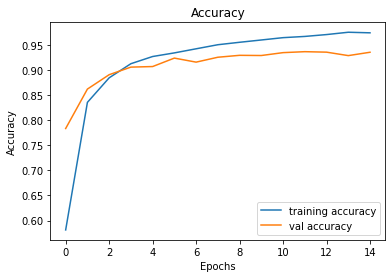

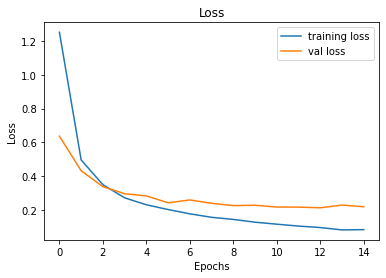

In [17]:
# Plotting graph for accuracy
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting graph for loss
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
# Saving the model.
model.save('model_vgg_nesterov.h5')

## Testing the model

In [19]:
# Using same transformations used in the training sets.
img_data_gen2 = ImageDataGenerator(
    rescale=1./255,           # Rescale used to normalize image values from between 0-255 to between 0-1.
    shear_range=SHEAR_RANGE,  # Shear range use to distort the image along an axis to augment images to accomadate for different viewing angles.
    zoom_range=ZOOM_RANGE,    # Zoom range applies a random zoom to the image to create a more varied dataset.
    horizontal_flip=True,     # Horizontal flip randomly flips images horizontally to create a more varied dataset.
)

# Shuffle set to false so that index of predictions correspond to the index of actual labels when used later on.
test_generator = img_data_gen2.flow_from_directory(
    'test',
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    batch_size = BATCH_SIZE,
    shuffle=False
)            

Found 900 images belonging to 10 classes.


In [20]:
# Evaluate performance against test set and work out accuracy and loss.
model.evaluate(test_generator, batch_size=BATCH_SIZE)

10/10 [==============================] - 16s 2s/step - loss: 0.1006 - accuracy: 0.9711


[0.10061555355787277, 0.9711111187934875]

## Confusion matrix and Metrics

In [21]:
test_labels = test_generator.classes    # Actual labels for each input image.
preds = model.predict(test_generator)   # Predicted probability distributions for each input image.
y_preds = np.argmax(preds, axis=-1)     # Predicted labels for each input image. (takes largest proability as predicted label)

In [22]:
# Calculate metrics such as Precision, Recall and F1-Score.
animals = ['Dog', 'Horse', 'Elephant', 'Butterfly', 'Chicken', 'Cat', 'Cow', 'Sheep', 'Spider', 'Squirrel']
print(metrics.classification_report(test_labels, y_preds, target_names=animals))

              precision    recall  f1-score   support

         Dog       0.88      0.98      0.93        90
       Horse       0.99      0.96      0.97        90
    Elephant       0.98      0.99      0.98        90
   Butterfly       0.99      0.99      0.99        90
     Chicken       0.99      0.96      0.97        90
         Cat       1.00      0.96      0.98        90
         Cow       0.99      0.94      0.97        90
       Sheep       0.97      0.99      0.98        90
      Spider       0.98      0.99      0.98        90
    Squirrel       0.97      0.97      0.97        90

    accuracy                           0.97       900
   macro avg       0.97      0.97      0.97       900
weighted avg       0.97      0.97      0.97       900



In [23]:
confusion_matrix = confusion_matrix(test_labels, y_preds) # Work out confusion matrix.

In [24]:
def pretty_confusion_matrix(confusion_matrix, classes, normalise=False):
    '''
    @param confusion_matrix: The confusion matrix produced by sk-learn to be made more visualy informative and pleasing.
    @param classes: The names of the class labels.
    @param normalise: Flag to determine whther or not to display normalised values instead of occurences in the confusion matrix.
    '''
    
    if normalise:
        print('Normalised', end=' ')
        # Divides each cell by the sum of the row
        confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
    print('Confusion Matrix')

    plt.figure(figsize=(10,10))
    plt.tight_layout()
    plt.title('Confusion Matrix')
    # Show confusion matrix using Blue accent colour as an image with varying colour intensities depending on value.
    plt.imshow(confusion_matrix, cmap=plt.cm.Blues)
    plt.colorbar() # Add colourbar showing what the intensity of colour represents.
    ticks = np.arange(len(classes)) # generate list of numbers upto the number of classes involved.
    plt.xticks(ticks, classes, rotation=45) # X-axis with rotated labels for readability. (Predicted labels)
    plt.yticks(ticks, classes) # Y-axis with labels (Actual labels)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    text_colour_threshold = np.max(confusion_matrix) / 2.0 # Value for which text colour on cell changes from black to white for visibility.
    
    # For each cell, writes the value of the cell in either black or white depending on what is best for visibility.
    for row, col in itertools.product(range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])):
        plt.text(col, row, format(confusion_matrix[row, col], '.2f'), horizontalalignment="center", color="white" if confusion_matrix[row, col] > text_colour_threshold else "black")
    
    

Confusion Matrix


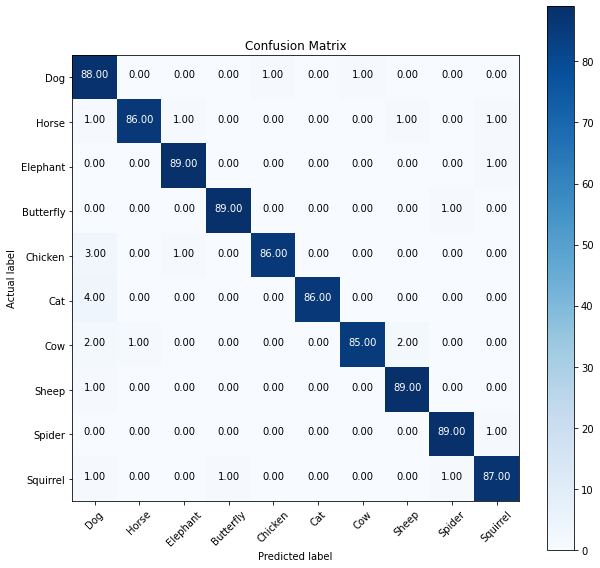

In [25]:
pretty_confusion_matrix(confusion_matrix, animals)

Normalised Confusion Matrix


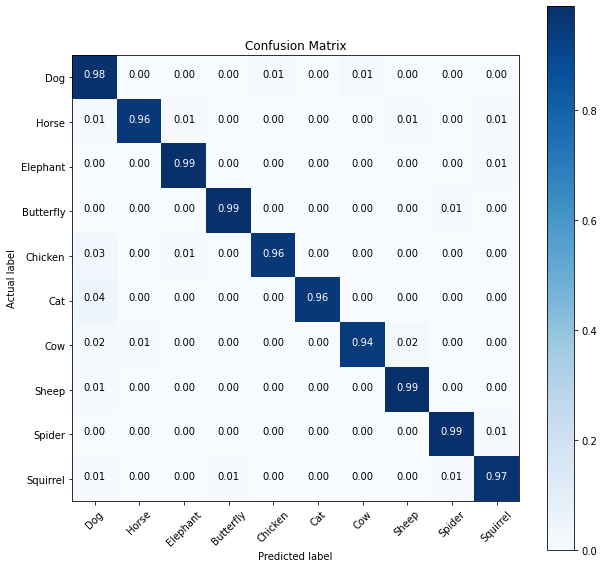

In [26]:
pretty_confusion_matrix(confusion_matrix, animals, normalise=True)